# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import  classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression

# Loading dataset

In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [3]:
X_train, y_train =  train.drop(["Depression"], axis=1), train["Depression"]
X_test, y_test =  test.drop(["Depression"], axis=1), test["Depression"]

In [4]:
train.head()

,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,1,26.0,10.0,4.0,9.24,5.0,1,2,15,1,10.0,2.0,1,1
1,1,24.0,24.0,2.0,9.93,1.0,3,1,21,1,10.0,3.0,0,1
2,0,32.0,20.0,5.0,9.24,4.0,2,1,8,1,7.0,4.0,0,1
3,1,21.0,0.0,4.0,8.59,4.0,1,2,7,0,10.0,1.0,1,0
4,0,31.0,29.0,3.0,6.61,4.0,0,2,17,0,12.0,2.0,0,0


# Preprocessing

In [5]:
categorical_columns = ["City", "Degree"]
continuous_columns = ["Age", "CGPA", "Work/Study Hours"]

In [6]:
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

continuous_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Standardize features
])

In [7]:
preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_columns),
    ('num', continuous_pipeline, continuous_columns)
],
 remainder='passthrough')

# Model training

In [8]:
lr = pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

In [9]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga']  # Solvers that support l1 and l2 penalties
}

In [10]:
grid_search = RandomizedSearchCV(estimator=lr, param_distributions=param_grid,  scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

In [11]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['City',
                                                                                'Degree']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'CGPA',
                                                                                'Work/Study '
                                                                                'Hours'])])),
                                             ('classifier',
                                              LogisticRegression(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.01, 0.1, 1, 10,
                                                          100],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'classifier__solver': ['liblinear',
                                                               'saga']},
                   scoring='accuracy', verbose=2)

# Model Evaluation

In [14]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated Accuracy: {grid_search.best_score_}")

Best Parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 0.1}
Best Cross-Validated Accuracy: 0.8471659343594743


In [15]:
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      2320
           1       0.85      0.89      0.87      3247

    accuracy                           0.84      5567
   macro avg       0.84      0.83      0.84      5567
weighted avg       0.84      0.84      0.84      5567



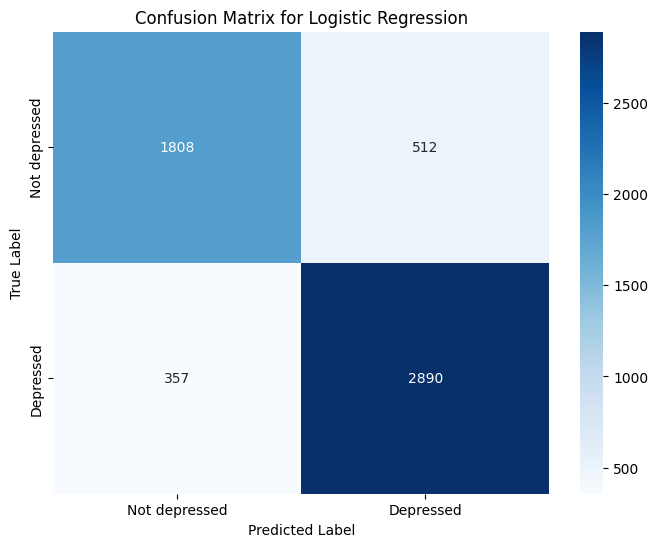

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not depressed", "Depressed"],
            yticklabels=["Not depressed", "Depressed"])
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# AUROC Curve

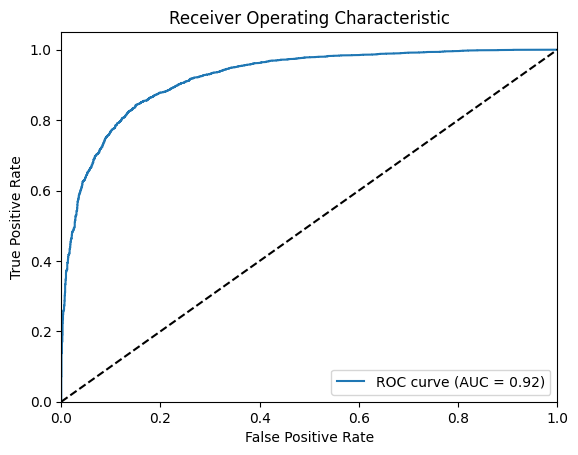

In [17]:
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature importance

In [18]:
# Get feature importances
coefficients = best_model.named_steps['classifier'].coef_[0]

# Get categorical feature names after one-hot encoding
categorical_features = best_model.named_steps['preprocessor'].transformers_[0][1] \
    .named_steps['onehot'].get_feature_names_out(categorical_columns)

# Passthrough features
passthrough_features = list(set(X_train.columns) - set(categorical_columns) - set(continuous_columns))

# Combine all features
all_features = np.hstack([categorical_features, continuous_columns, passthrough_features])

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': coefficients
}).sort_values(by='Importance', key=abs, ascending=False)

feature_importance.head(100)

,Feature,Importance
65,Study Satisfaction,2.475303
61,Academic Pressure,0.817742
57,Age,-0.565639
66,Dietary Habits,0.550351
64,Family History of Mental Illness,0.540444
...,...,...
1,City_1.0,0.000000
35,Degree_5,0.000000
37,Degree_7,0.000000
39,Degree_9,0.000000
